<a href="https://colab.research.google.com/github/bksgupta/course-v3/blob/master/lesson5_sgd_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [2]:
Config.data_path()

PosixPath('/root/.fastai/data')

In [3]:
path = Config().data_path()/'mnist'

In [4]:
path.mkdir(parents=True)

In [5]:
path.ls()

[]

In [6]:
Config().data_path().ls()

[PosixPath('/root/.fastai/data/mnist')]

In [7]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz -P {path}

--2020-07-11 17:31:37--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘/root/.fastai/data/mnist/mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  5.76MB/s    in 2.7s    

2020-07-11 17:31:40 (5.76 MB/s) - ‘/root/.fastai/data/mnist/mnist.pkl.gz’ saved [16168813/16168813]



In [8]:
path.ls()

[PosixPath('/root/.fastai/data/mnist/mnist.pkl.gz')]

In [20]:
  with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

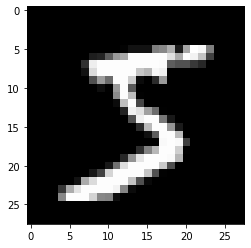

In [21]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [22]:
type(x_train),type(y_train)

(numpy.ndarray, numpy.ndarray)

In [23]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [24]:
n,c

(50000, 784)

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [25]:
y_train

tensor([5, 0, 4,  ..., 8, 4, 8])

In [29]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [30]:
len(train_ds)

50000

In [31]:
len(valid_ds)

10000

In [33]:
data.train_ds

In [34]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [35]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [36]:
model = Mnist_Logistic().cuda()

In [37]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [38]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [39]:
model(x).shape

torch.Size([64, 10])

In [40]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [41]:
lr=2e-2

In [42]:
y

tensor([4, 5, 6, 8, 6, 3, 6, 4, 8, 7, 7, 1, 6, 0, 9, 8, 3, 5, 8, 0, 8, 2, 9, 3,
        5, 4, 9, 4, 5, 4, 4, 9, 9, 3, 6, 7, 9, 0, 7, 1, 5, 5, 0, 5, 0, 9, 1, 3,
        4, 0, 1, 2, 8, 6, 6, 2, 7, 0, 2, 5, 9, 1, 0, 4], device='cuda:0')

In [43]:
loss_func = nn.CrossEntropyLoss()

In [46]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [52]:
losses = [update(x,y,lr) for x,y in data.train_dl]

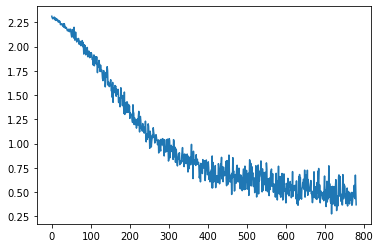

In [53]:
plt.plot(losses);

In [54]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [55]:
model = Mnist_NN().cuda()

In [56]:
losses = [update(x,y,lr) for x,y in data.train_dl]

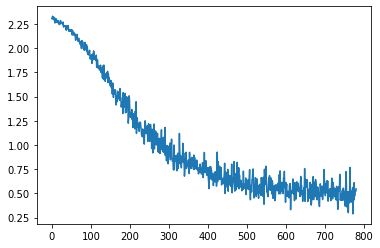

In [57]:
plt.plot(losses);

In [58]:
model = Mnist_NN().cuda()

In [59]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [60]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

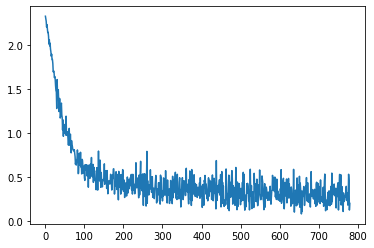

In [61]:
plt.plot(losses);

In [62]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [ ]:
%debug

> /home/ubuntu/fastai/fastai/basic_data.py(20)DataLoader___getattr__()
     18 torch.utils.data.DataLoader.__init__ = intercept_args
     19 
---> 20 def DataLoader___getattr__(dl, k:str)->Any: return getattr(dl.dataset, k)
     21 DataLoader.__getattr__ = DataLoader___getattr__
     22 

ipdb> u
> /home/ubuntu/fastai/fastai/basic_data.py(38)__getattr__()
     36 
     37     def __len__(self)->int: return len(self.dl)
---> 38     def __getattr__(self,k:str)->Any: return getattr(self.dl, k)
     39     def __setstate__(self,data:Any): self.__dict__.update(data)
     40 

ipdb> print(k)
loss_func
ipdb> q


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


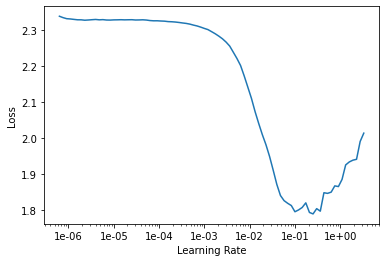

In [63]:
learn.lr_find()
learn.recorder.plot()

In [64]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.152602,0.139540,0.961700,00:05


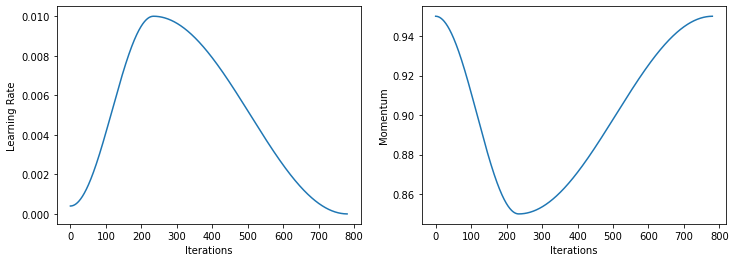

In [65]:
learn.recorder.plot_lr(show_moms=True)

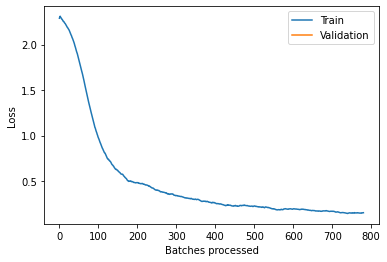

In [66]:
learn.recorder.plot_losses()

## fin